In [36]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd 
import gzip
import json
import sklearn
import os
from collections import defaultdict
import string
import matplotlib.pyplot as plt

def load_data_se(file_name, start=200000, end=200001, sep=True):
    if (start is not None) and (end is not None) and (end > start):
        count = 0
        data = []
        with gzip.open(file_name) as fin:
            for l in fin:
                count += 1
                if count >= start:
                    d = json.loads(l)
                    if sep == True:
                        bid, title, tws = d['book_id'], d['title'], d['title_without_series']
                        data.append((bid, title, tws))
                    else:
                        data.append(d)
                if (count == end):
                    break
    return data

def load_data(file_name, head=200000, sep=True):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            if sep == True:
                bid, title, tws = d['book_id'], d['title'], d['title_without_series']
                data.append((bid, title, tws))
            else:
                data.append(d)
            
            if (head is not None) and (count > head):
                break
    return data

def load_json(path, head=5000):
    df = []
    f = open(path, 'rt', encoding='utf-8')
    f.readline()
    for l in f:
        d = eval(l)
        df.append(d)
    return df

### Loading Data

In [2]:
gr_books = load_data("goodreads_books.json.gz", head=1e8)

In [41]:
sentences_df = load_data('goodreads_reviews_spoiler.json.gz', sep=False, head=200000)
# text_df = load_data('goodreads_reviews_spoiler_raw.json.gz')

In [42]:
train_df, val_df, test_df = sentences_df[:160000], sentences_df[160000:180000], sentences_df[180000:]

### Feature Engineering

In [43]:
sl_pairs = []
cnt_has_spoiler_text, cnt_has_spoiler_sentence = 0, 0
total_sentences = 0
word_count = defaultdict(int)
punctuation = set(string.punctuation)
uids, bids = defaultdict(int), defaultdict(int)
spoiled_items, spoilers = [], []
num_rev_per_user, num_rev_per_item = [], []

for d in train_df:
    sentences = d['review_sentences']
    cnt_has_spoiler_text += d['has_spoiler']
    b, u = d['book_id'], d['user_id']
    if b not in bids:
        bids[b] = len(bids)
        spoiled_items.append(int(d['has_spoiler']))
        num_rev_per_item.append(1)
    else:
        bid = bids[b]
        spoiled_items[bid] += d['has_spoiler']
        num_rev_per_item[bid] += 1
    if u not in uids:
        uids[u] = len(uids)
        spoilers.append(int(d['has_spoiler']))
        num_rev_per_user.append(1)
    else:
        uid = uids[u]
        spoilers[uid] += d['has_spoiler']
        num_rev_per_user[uid] += 1
    for indicator, sentence in sentences:
        cnt_has_spoiler_sentence += indicator
        total_sentences += 1
        sl_pairs.append((indicator, sentence))
        r = ''.join([c for c in sentence if not c in punctuation])
        for w in r.split():
            word_count[w] += 1
print("# of Reviews: ", len(train_df), "; # of has spoiler review: ", cnt_has_spoiler_text)
print("# of sentences: ", total_sentences, "; # of has spoiler sentence: ", cnt_has_spoiler_sentence)
print("# of words: ", len(word_count.keys()))

# of Reviews:  160000 ; # of has spoiler review:  10208
# of sentences:  1962170 ; # of has spoiler sentence:  58956
# of words:  255260


In [44]:
user_spoil_proportion = list(np.array(spoilers) / np.array(num_rev_per_user))
book_spoil_proportion = list(np.array(spoiled_items) / np.array(num_rev_per_item))

In [57]:
book_ids = {}
for bid, title, tws in gr_books:
    book_ids[bids[bid]] = title

1964 23268


Text(0.5, 1.0, "# of 'Has Spoiler' Review for books")

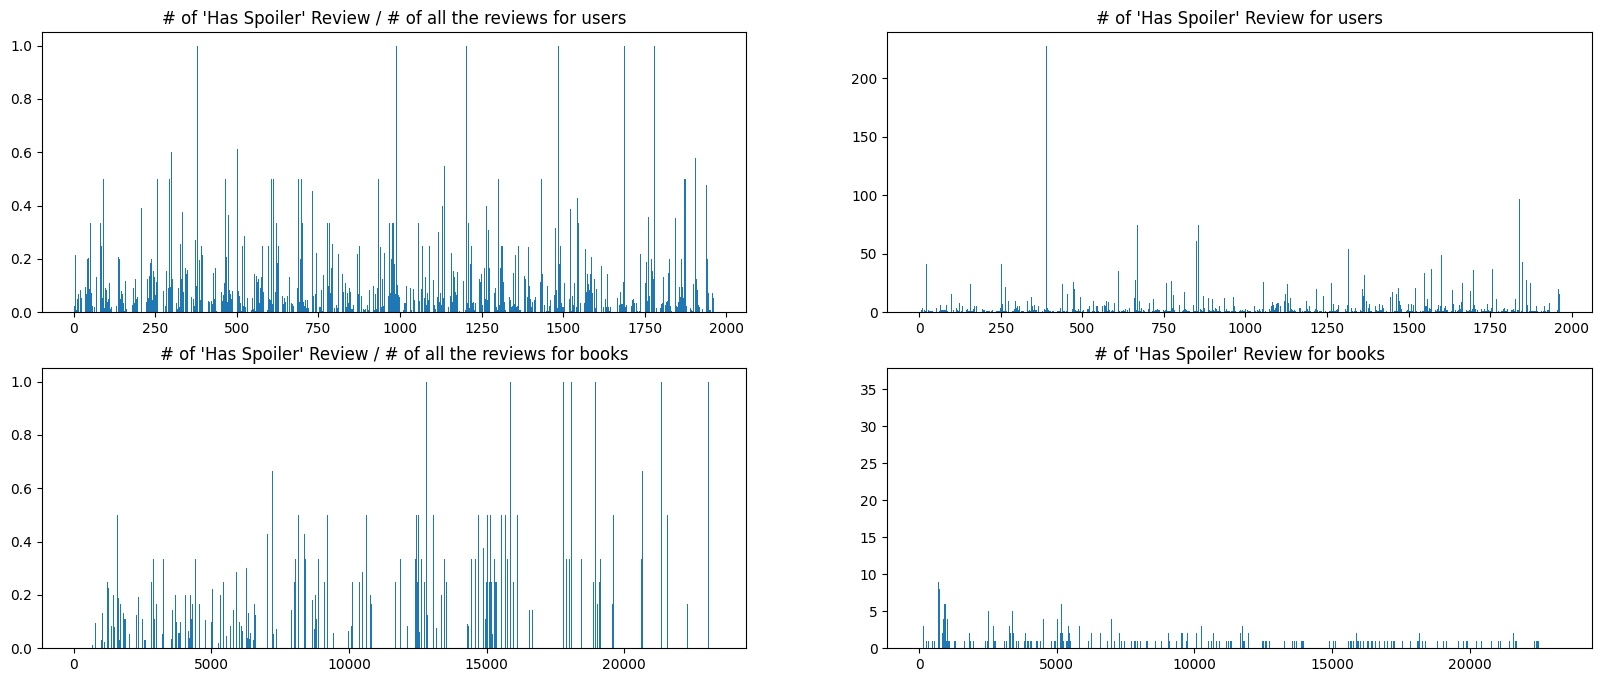

In [67]:
user_num, book_num = len(uids), len(bids)
print(user_num, book_num)
xu, xb = list(range(0, user_num)), list(range(0, book_num))
fig = plt.figure (figsize=(20, 8))
plt.subplot(2, 2, 1)
plt.bar(xu, user_spoil_proportion)
plt.title("# of 'Has Spoiler' Review / # of all the reviews for users")
plt.subplot(2, 2, 3)
plt.bar(xb, book_spoil_proportion)
plt.title("# of 'Has Spoiler' Review / # of all the reviews for books")
plt.subplot(2, 2, 2)
plt.bar(xu, spoilers)
plt.title("# of 'Has Spoiler' Review for users")
plt.subplot(2, 2, 4)
plt.bar(xb, spoiled_items)
plt.title("# of 'Has Spoiler' Review for books")

### DF-IIF

In [84]:
counts = [(word_count[w], w) for w in word_count]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:10000]]
user_num, book_num = len(uids), len(bids)

In [85]:
df_per_item = defaultdict(dict)
df = defaultdict(int)
for d in train_df:
    u, b = d['user_id'], d['book_id']
    r = ''
    for i, sentence in d['review_sentences']:
        s = ''.join([c for c in sentence if not c in punctuation])
        r += ' ' + s
    for w in set(r.split()):
        if bids[b] not in df_per_item[w]:
            df_per_item[w][bids[b]] = 1
        else:
            df_per_item[w][bids[b]] += 1
        df[w] += 1

for w in df_per_item:
    for b in df_per_item[w]:
        df_per_item[w][b] /= num_rev_per_item[b]

In [86]:
if_ = defaultdict(set)
    
for d in train_df:
    u, b = d['user_id'], d['book_id']
    r = ''
    for i, sentence in d['review_sentences']:
        s = ''.join([c for c in sentence if not c in punctuation])
        r += ' ' + s
    for w in set(r.split()):
        if_[w].add(bids[b])

for w in if_:
    if_[w] = len(if_[w]) / book_num

In [154]:
def sentence_DF_IIF(sentence, bid):
    avg_df_iif = 0
    word_num = 0
    for w in sentence.split():
        if bid not in df_per_item[w]:
            w_df_iif = 1e-6
        else:
            w_df_iif = df_per_item[w][bid] * np.log10(1 / if_[w])
        avg_df_iif += w_df_iif
        word_num += 1
    if word_num == 0:
        print(sentence)
    return avg_df_iif / word_num

In [135]:
import math

def cosine(x1, x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1, a2 in zip(x1, x2):
        numer += a1 * a2
        norm1 += a1 ** 2
        norm2 += a2 ** 2
    if norm1 * norm2:
        return numer / math.sqrt(norm1 * norm2)

def rev_title_similarity(sentence, bid):
    tf_sen, tf_title = defaultdict(int), defaultdict(int)
    for w in sentence.split():
        tf_sen[w] += 1
    for w in book_ids[bid].split():
        tf_title[w] += 1
    sentence_tf_idf, title_tf_idf = [0, ] * 10000, [0, ] * 10000
    i = 0
    for w in words:
        sentence_tf_idf[i] = (tf_sen[w] * np.log2(len(train_df) / df[w]))
        title_tf_idf[i] = (tf_title[w] * np.log2(len(train_df) / df[w]))
        i += 1
    return cosine(sentence_tf_idf, title_tf_idf)


### Trial 1: Extracted Features + Logistic Regression

In [157]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [149]:
import time
X_train, y_train = [], []
for d in train_df:
    uid, bid = uids[d['user_id']], bids[d['book_id']]
    u_prop, i_prop = user_spoil_proportion[uid], book_spoil_proportion[bid]
    for j, sentence in d['review_sentences']:
        s = ''.join([c for c in sentence if not c in punctuation])
        if len(s) == 0 or len(s.replace(" ", "")) == 0:
            continue
        avg_df_iif = sentence_DF_IIF(s, bid)
        # rev_t_sim = rev_title_similarity(s, bid)
        X_train.append((u_prop, i_prop, avg_df_iif))
        y_train.append(j)

In [155]:
X_val, y_val = [], []
for d in val_df:
    uid, bid = uids[d['user_id']], bids[d['book_id']]
    u_prop, i_prop = user_spoil_proportion[uid], book_spoil_proportion[bid]
    for j, sentence in d['review_sentences']:
        s = ''.join([c for c in sentence if not c in punctuation])
        if len(s) == 0 or len(s.replace(" ", "")) == 0:
            continue
        avg_df_iif = sentence_DF_IIF(s, bid)
        # rev_t_sim = rev_title_similarity(s, bid)
        X_val.append((u_prop, i_prop, avg_df_iif))
        y_val.append(j)

X_test, y_test = [], []
for d in test_df:
    uid, bid = uids[d['user_id']], bids[d['book_id']]
    u_prop, i_prop = user_spoil_proportion[uid], book_spoil_proportion[bid]
    for j, sentence in d['review_sentences']:
        s = ''.join([c for c in sentence if not c in punctuation])
        if len(s) == 0 or len(s.replace(" ", "")) == 0:
            continue
        avg_df_iif = sentence_DF_IIF(s, bid)
        # rev_t_sim = rev_title_similarity(s, bid)
        X_test.append((u_prop, i_prop, avg_df_iif))
        y_test.append(j)

In [175]:
cls = LogisticRegression(C=1)
cls.fit(X_train, y_train)
y_val_pred = cls.predict(X_val)
y_test_pred = cls.predict(X_test)
print(accuracy_score(y_val_pred, y_val), precision_score(y_val_pred, y_val), recall_score(y_val_pred, y_val), f1_score(y_val_pred, y_val))
print(accuracy_score(y_test_pred, y_test), precision_score(y_test_pred, y_test), recall_score(y_test_pred, y_test), f1_score(y_test_pred, y_test))

0.9707877858567872 0.005053145147238195 0.020625889046941678 0.008117564730580826
0.9655407251374927 0.0028594771241830064 0.014989293361884369 0.004802744425385934
